In [1]:
# dependencies (numpy, matplotlib, and keras)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import tensorflow as tf


Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [168]:
input_shape = 784
batch_size = 100
hidden_dim = 250
features = 2
nb_epoch = 5

#Encoder Begin
X_input = Input(batch_shape = (batch_size,input_shape))
hidden = Dense(hidden_dim, activation='relu')(X_input)

#Begin the Squeeze
mean = Dense(features,name='Mean')
Z_mean = mean(hidden)
variance = Dense(features,name='Variance')
Z_variance = variance(hidden)



In [169]:
#Begin the Sampling function
def sample(args):
    Z_mean, Z_var = args
    epsilon = K.random_normal(shape=(batch_size, features), mean=0.)
    return Z_mean + K.exp(Z_variance / 2) * epsilon
#Wrapping into a tensor shape
Z = Lambda(sample, output_shape=(features,),name="Z_Sampling")([Z_mean, Z_variance])

In [170]:
#Decoder begin
dec_hidden = Dense(hidden_dim, activation = 'relu')
decoder_hidden = dec_hidden(Z)
dec_X = Dense(input_shape, activation = 'sigmoid')
decoder_X = dec_X(decoder_hidden)

#loss
def vae_loss(X_input, decoder_X):
    xent_loss = input_shape * objectives.binary_crossentropy(X_input, decoder_X)
    kl_loss = - 0.5 * K.sum(1 + Z_variance - K.square(Z_mean) - K.exp(Z_variance), axis=-1)
    return xent_loss + kl_loss

vae = Model(X_input, decoder_X)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [171]:
#Train
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)


vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)

(60000, 28, 28)
(60000, 784)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 169us/step - loss: 191.0848 - val_loss: 173.0340
Epoch 2/5
60000/60000 [==============================] - 9s 144us/step - loss: 169.7395 - val_loss: 167.4386
Epoch 3/5
60000/60000 [==============================] - 8s 125us/step - loss: 165.4499 - val_loss: 164.2953
Epoch 4/5
60000/60000 [==============================] - 7s 123us/step - loss: 162.8312 - val_loss: 162.1993
Epoch 5/5
60000/60000 [==============================] - 8s 129us/step - loss: 160.9120 - val_loss: 160.1521


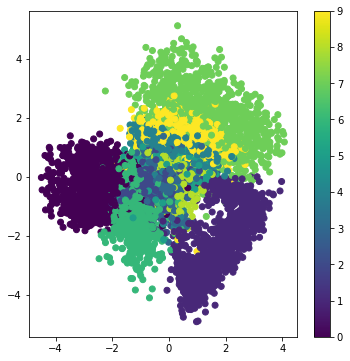

In [172]:
#plot latent/hidden space

# build a model to project inputs on the latent space
encoder = Model(X_input, Z)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap="viridis")
plt.colorbar()
plt.show()

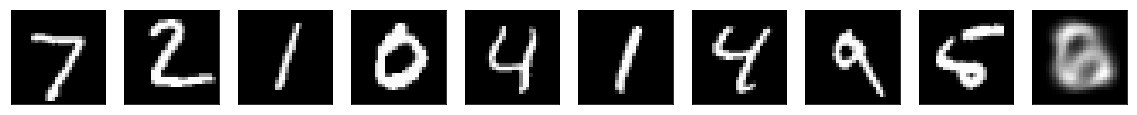

In [193]:
decodeInp = Input(shape = (features,))
decodeInp2 = dec_hidden(decodeInp)
decodeInp3 = dec_X(decodeInp2)
decodee = Model(decodeInp, decodeInp3)
encodedImg = encoder.predict(x_test, batch_size=batch_size)
decodedImg = decodee.predict(encodedImg, batch_size=batch_size)


grid_x = norm.ppf(np.linspace(0.05, 0.95, 5))
grid_y = norm.ppf(np.linspace(0.05, 0.95, 5))

n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#     ax = plt.subplot(2,n,i+1+n)
#     plt.imshow(decodedImg[i].reshape((28,28)),cmap='gray')
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
    


f =[[-1,0.2]]
f=np.asarray(f)
fren = decodee.predict(f)
plt.imshow(fren.reshape((28,28)),cmap='gray')
# encodedImg[3]

In [ ]:
encoded_outputs = encoder.predict()
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
plt.close()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (100, 784)           0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (100, 250)           196250      input_6[0][0]                    
__________________________________________________________________________________________________
Mean (Dense)                    (100, 2)             502         dense_15[0][0]                   
__________________________________________________________________________________________________
Variance (Dense)                (100, 2)             502         dense_15[0][0]                   
__________________________________________________________________________________________________
Z_Sampling

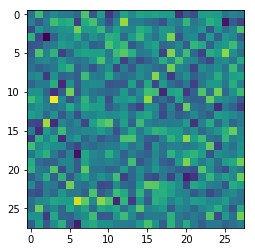

In [138]:
#Decoder
vae.summary()



inputLayer = Input(shape=(features,))
h1 = Dense(hidden_dim, activation = 'relu')(inputLayer)
h2 = Dense(input_shape, activation = 'sigmoid')(h1)
decoderH = Model(inputLayer, h2)

encodedImages = encoder.predict(x_test, batch_size=batch_size)
decodedImages = decoderH.predict(encodedImages,batch_size=batch_size)
grid_x = np.linspace(0.05, 0.95, 5)
grid_y = np.linspace(0.05, 0.95, 5)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        f = np.array([[xi,yi]])
print(f)
fren = decoderH.predict(f)
fren = fren[0].reshape(28,28)
plt.imshow(fren)

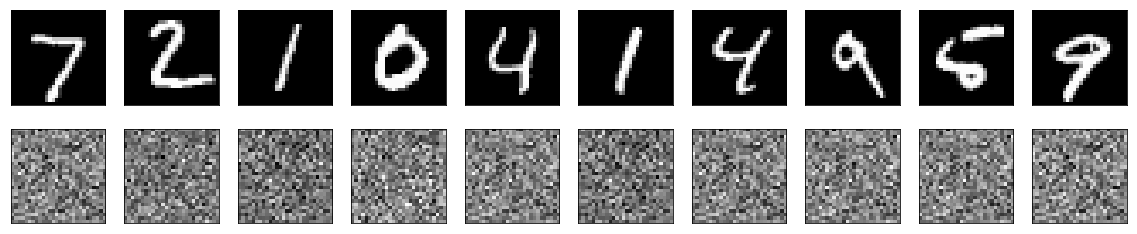

In [106]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(decodedImages[i].reshape((28,28)),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [108]:
decoderrrr = Model(Z, decoder_X)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_6:0", shape=(100, 784), dtype=float32) at layer "input_6". The following previous layers were accessed without issue: []